# Merging multiple objectives to a scalar target for single-target BO

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import bofire.strategies.api as strategies
from bofire.benchmarks.api import DTLZ2
from bofire.data_models.objectives import api as objectives_data_model
from bofire.data_models.strategies import api as strategies_data_model

## Benchmark Problem 
Only used for domain definition

In [ ]:
bench = DTLZ2(dim=2, num_objectives=2)
experiments = bench.f(bench.domain.inputs.sample(10), return_complete=True)

domain = bench.domain

### Change the objectives: Multiplication, only reasonable for objectives > 0

In [ ]:
outputs = domain.outputs.get_by_objective()

outputs[0].objective = objectives_data_model.MaximizeObjective(w=1.0, bounds=(0.0, 5.0))
outputs[1].objective = objectives_data_model.MaximizeObjective(w=1.0, bounds=(0.0, 2.0))
# outputs[1].objective = objectives_data_model.MaximizeSigmoidObjective(w = 0.5, tp=2.5, steepness=3.)

## Select Strategies
We will use pure multiplicative and additive Sobo strategies, as well as a mixed one for this example:
- Multiplicative: $f = f_0^{w_0} \cdot f_1^{w_1}$
- Additive: $f = f_0 \cdot w_0 + f_1 \cdot w_1$
- Mixed (with f1 being the additive objective): $f = f_0^{w_0} \cdot (1 + w_1 \cdot f_1)$

In [ ]:
strategy_data_model = {
    "multiplicative": strategies_data_model.MultiplicativeSoboStrategy(domain=domain),
    "additive": strategies_data_model.AdditiveSoboStrategy(domain=domain),
    "mixed": strategies_data_model.MultiplicativeAdditiveSoboStrategy(
        domain=domain, additive_features=["f_1"]
    ),
}

### We will now create the strategies and evaluate them on a grid to visualize the objectives.
We see the following:
- Multiplicative: The objective is a product of the objectives: If either $f_0$ or $f_1$ is low, the objective is low.
- Additive: The objective is a sum of the objectives: We see a linear increase in the objective with increasing $f_0$ and $f_1$. This is useful for complementary objectives.
- Mixed: The objective is more strict w.r.t. $f_0$ than the additive objective $f_1$. The overall desirability can also be high, if $f_1$ is low.

Changing the weights $w_i$ in the objectives above will further change the preference of $f_0$ and $f_1$. 

In [ ]:
# map from the strategy data-model to the actual strategy object instances
strategy = {
    key: strategies.map(strategy_data_model)
    for (key, strategy_data_model) in strategy_data_model.items()
}

In [ ]:
# tell the strategies about the experiments. This is required to set up the models, but not for the objective evaluation
for _, strat in strategy.items():
    strat.tell(experiments)

In [ ]:
# get the objectives for evaluation as a torch executable
objectives = {
    key: strategy._get_objective_and_constraints()[0]
    for (key, strategy) in strategy.items()
}

In [ ]:
# f_0 / f_1 coordinates for objctive evaluation
mesh = np.meshgrid(np.linspace(0, 2, 100), np.linspace(0, 5, 100))
# transform to matrix-form torch tensor
mesh_tensor = torch.tensor([m.flatten() for m in mesh]).T

In [ ]:
# evaluate objectives
objectives_eval = {
    key: obj(mesh_tensor).detach().numpy().reshape(mesh[0].shape)
    for (key, obj) in objectives.items()
}

/var/folders/nz/mktm3tp93bb8z4cp_xyjgtzr0000gn/T/ipykernel_6246/3646907364.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(*mesh, obj, label=key)


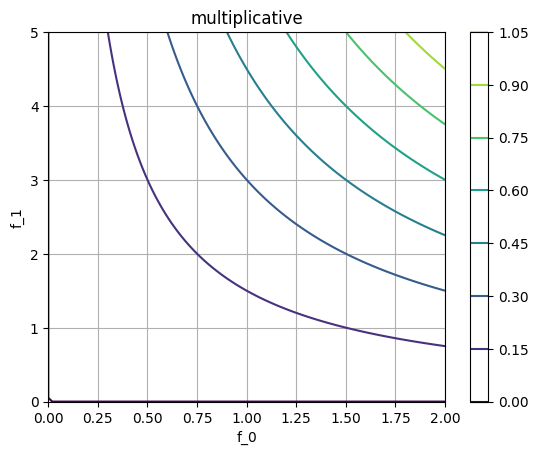

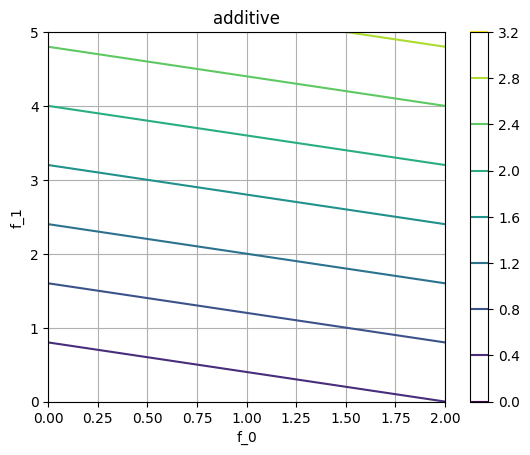

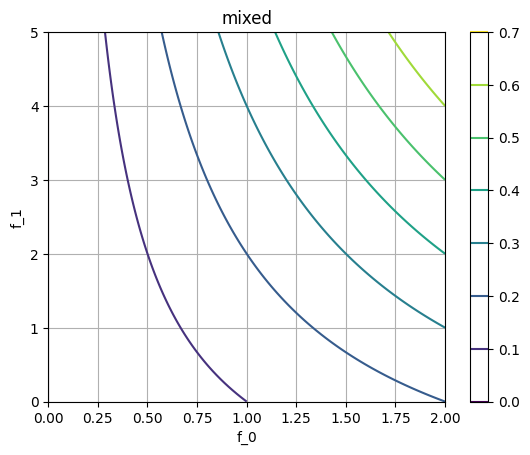

In [ ]:
# plot the objectives as contour plots
for key, obj in objectives_eval.items():
    plt.figure()
    plt.contour(*mesh, obj, label=key)
    plt.title(key)
    plt.xlabel("f_0")
    plt.ylabel("f_1")
    plt.grid(True)
    plt.colorbar()

plt.show()